In [230]:
import os

import threading 
import mediapipe as mp
from mediapipe.tasks.python import BaseOptions
from mediapipe.tasks.python.vision import GestureRecognizer, GestureRecognizerOptions, GestureRecognizerResult, RunningMode
import cv2 

from IPython.display import display, HTML

from PIL import Image as PILImage

from dm_control import mujoco
from dm_control.rl import control
from dm_control.suite import base

import numpy as np
import time

from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib

from tqdm import tqdm

from constants import *

import pyrealsense2 as rs

In [231]:
class SimTask(base.Task):

    def __init__(self, random=None):
        super(SimTask, self).__init__(random=random)

    def initialize_episode(self, physics):
        with physics.reset_context():
            physics.named.data.qpos[:6] = UR10E_START_POS
            np.copyto(physics.data.ctrl, UR10E_START_POS)
        
        np.copyto(physics.data.mocap_pos[0], physics.named.data.xpos['wrist_3_link'])
        np.copyto(physics.data.mocap_quat[0], physics.named.data.xquat['wrist_3_link'])

        super().initialize_episode(physics)

    def before_step(self, action, physics):
        np.copyto(physics.data.mocap_pos[0], action[0:3])
        np.copyto(physics.data.mocap_quat[0], action[3:7])
    
    def get_observation(self, physics):
        return {
            'images': {
                'top': physics.render(height=240, width=320, camera_id=0),
                'birdview': physics.render(height=240, width=320, camera_id=1),
                'front': physics.render(height=240, width=320, camera_id=2)
            }, 'mocap': {
                'pos': physics.data.mocap_pos[0],
                'quat': physics.data.mocap_quat[0]
            }
        }
    
    def get_reward(self, physics):
        return 0
    
    def get_joint_poses(self, physics):
        # Get the joint positions from the Mujoco physics simulation
        joint_poses = physics.named.data.qpos[6:]
        return joint_poses
        
    
    @staticmethod
    def get_env(control_timestamp_sec=0.02):
        physics = mujoco.Physics.from_xml_path(SCENE_XML_PATH)

        task = SimTask()
        env = control.Environment(
            physics, task, time_limit=10., control_timestep=control_timestamp_sec,
            n_sub_steps=None, flat_observation=None)
        return env
    

In [232]:
class HandTrackingSession:

    def __init__(self, num_frames=100, framerate=30,control_scale=0.5,control_timestep=0.2,render_robot=False) -> None:

        self.pipeline = rs.pipeline()
        self.config = rs.config()  
        pipeline_wrapper = rs.pipeline_wrapper(self.pipeline)  
        pipeline_profile = self.config.resolve(pipeline_wrapper)  
        device = pipeline_profile.get_device()  
        self.device_product_line = str(device.get_info(rs.camera_info.product_line))  
        found_rgb = False
        for s in device.sensors:
            if s.get_info(rs.camera_info.name) == 'RGB Camera':
                found_rgb = True
                break
        if not found_rgb:
            print("Double check your camera")
            exit(0)
        self.config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, framerate)
        self.config.enable_stream(rs.stream.color, 640, 480, rs.format.rgb8, framerate)  
        self.pipeline.start(self.config)  

        self.camera_display_handle = None
        self.simulation_display_handle = None

        self.env = SimTask.get_env(control_timestamp_sec=control_timestep)
        self.num_frames = num_frames
        self.framerate = framerate

        self.control_scale = control_scale

        self.render_robot = render_robot

        self.controls = []
        self.camera_frames = []

        self.simulation_frames = []

        self.init_mocap_pos = None
        self.init_mocap_quat = None

    def callback(self, result: GestureRecognizerResult, output_image: mp.Image, timestamp: int):
        '''
        Async callback function for the gesture recognizer
        '''
        if (len(result.hand_landmarks) > 0):
            landmark = result.hand_landmarks[0][0]
            hand_pos = np.array([landmark.x, landmark.z, landmark.y])
            # print(hand_pos, end='\r')
        
            self.controls.append(hand_pos)
        else:
            if (len(self.controls) > 0):
                self.controls.append(self.controls[-1])
            else:
                self.controls.append(np.zeros(3))
        
        camera_frame = output_image.numpy_view()
        self.camera_frames.append(camera_frame)
        
        self.camera_display_handle.update(PILImage.fromarray(camera_frame))

    @staticmethod
    def display_video(frames, framerate=30):
        height, width, _ = frames[0].shape
        dpi = 70
        orig_backend = matplotlib.get_backend()
        matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
        fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
        matplotlib.use(orig_backend)  # Switch back to the original backend.
        ax.set_axis_off()
        ax.set_aspect('equal')
        ax.set_position([0, 0, 1, 1])
        im = ax.imshow(frames[0])
        def update(frame):
            im.set_data(frame)
            return [im]
        interval = 2000/framerate
        anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                        interval=interval, blit=True, repeat=False)
        return HTML(anim.to_html5_video())
    
    def setup_env(self, physics):
        ts = self.env.reset()
        self.init_mocap_pos = ts.observation['mocap']['pos'].copy()
        self.init_mocap_quat = ts.observation['mocap']['quat'].copy()
        self.init_mocap_qpos = physics.data.qpos.copy()
        self.simulation_frames = [ts.observation['images']['birdview']]
    
    def render_one_frame(self, ctrl_pos):
        ts = self.env.step(np.concatenate([ctrl_pos * self.control_scale + self.init_mocap_pos, 
                                           self.init_mocap_quat]) 
                           )
        print(ts)
        current_joint_poses = self.env.task.get_joint_poses(self.env.physics)
        print(current_joint_poses)
        return ts.observation['images']['birdview']

    def render(self):
        

        joint_poses_sequence = []  # Initialize list to store joint poses
        
        for i in tqdm(range(self.num_frames)):
            # Render one frame and append to the simulation frames
            self.simulation_frames.append(self.render_one_frame(self.controls[i]))
            
            # Get the current joint poses and append to the sequence
            current_joint_poses = self.env.task.get_joint_poses(self.env.physics)  # You need to implement this method in your SimTask class
            joint_poses_sequence.append(current_joint_poses)
 
        # Return both the rendered frames and the joint poses sequence
        return self.display_video(self.simulation_frames, framerate=self.framerate)
    
    def start(self):
        self.controls = []
        self.camera_frames = []
        physics = mujoco.Physics.from_xml_path(SCENE_XML_PATH)
        self.setup_env(physics)

        self.camera_display_handle = display(None, display_id=True)

        options = GestureRecognizerOptions(
            base_options=BaseOptions(model_asset_path=MODEL_ASSET_PATH),
            running_mode=RunningMode.IMAGE,
            # result_callback=self.callback
            )
        
        timestamp = 0
        with GestureRecognizer.create_from_options(options) as recognizer:

            def render_frames():
                if self.controls:
                    ts = self.env.step(np.concatenate([self.controls[-1] * self.control_scale + self.init_mocap_pos, self.init_mocap_quat]))
                    current_qpos = self.env.physics.data.qpos.copy()
                    print(current_qpos)
                    birdview_image = ts.observation['images']['birdview']
                    self.camera_display_handle.update(PILImage.fromarray(birdview_image))
                                    
            render_thread = threading.Thread(target=render_frames)
            render_thread.start()
            
            while True:
                frames = self.pipeline.wait_for_frames()
                depth_frame = frames.get_depth_frame()
                color_frame = frames.get_color_frame()
                if not color_frame or not depth_frame:
                    continue
                timestamp += 1
                depth_image = np.asanyarray(depth_frame.get_data())
                color_image = np.asanyarray(color_frame.get_data())
                depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
                depth_colormap_dim = depth_colormap.shape
                color_colormap_dim = color_image.shape
                if depth_colormap_dim != color_colormap_dim:
                    resized_color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
                    images = np.hstack((resized_color_image, depth_colormap))
                else:
                    images = np.hstack((color_image, depth_colormap))

                mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=images)
                hand_landmarker_result = recognizer.recognize(mp_image)
                if hand_landmarker_result and hand_landmarker_result.hand_landmarks:
                    landmark = hand_landmarker_result.hand_landmarks[0][0]
                    hand_pos = np.array([landmark.x, landmark.z, landmark.y])
                    self.controls.append(hand_pos)
                    render_frames()
                else:
                    # If no hand landmarks detected, append zeros
                    self.controls.append(np.zeros(3))
                    
                cv2.imshow("Camera Feed", color_image)

                if cv2.waitKey(1000 // self.framerate) & 0xFF == ord('q'):
                    break

                if timestamp == self.num_frames + 100:
                    break

        render_thread.join()
        
    def close(self):
        self.pipeline.stop()
        cv2.destroyAllWindows()


In [243]:
session = HandTrackingSession(framerate=60, render_robot=False)

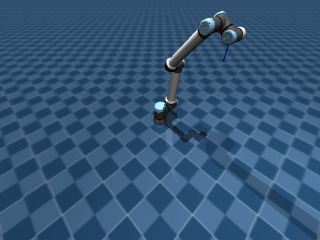

[-0.26982933 -1.46296474  0.83977755  0.57730484 -0.26805368  0.03949031]


I0000 00:00:1713465952.214801   54507 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1713465952.316331   61668 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.171.04), renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2
W0000 00:00:1713465952.316768   54507 gesture_recognizer_graph.cc:129] Hand Gesture Recognizer contains CPU only ops. Sets HandGestureRecognizerGraph acceleration to Xnnpack.
I0000 00:00:1713465952.317984   54507 hand_gesture_recognizer_graph.cc:250] Custom gesture classifier is not defined.


[-0.26888798 -1.4751191   0.86154796  0.53038285 -0.26511986  0.07754514]
[-0.26757748 -1.47888555  0.8707673   0.52031119 -0.26391171  0.0823066 ]
[-0.26817183 -1.46970033  0.84736953  0.5434549  -0.26477096  0.07314851]
[-0.26555542 -1.46585417  0.834254    0.5466247  -0.26197548  0.07926138]
[-0.1565532  -1.37834718  0.53158708  0.50632558 -0.14860203  0.32371618]
[-0.13945524 -1.47249918  0.71709997  0.1437004  -0.11310425  0.60524535]
[-0.12691258 -1.50218698  0.77785402  0.02676456 -0.09508465  0.69114169]
[-0.12776405 -1.51490802  0.83712247  0.07670163 -0.10265248  0.59450303]
[-0.11982516 -1.52137992  0.87156559  0.09228714 -0.09932344  0.55149765]
[-0.11925955 -1.52693708  0.89615247  0.09973259 -0.10026689  0.52526268]
[-0.12035589 -1.52818885  0.91667495  0.13766331 -0.10443643  0.46813741]
[-0.23149138 -1.41057041  0.67289748  0.60837653 -0.22727218  0.1242419 ]
[-0.21301058 -1.49845409  0.90355937  0.41969439 -0.20693617  0.17031791]
[-0.20177656 -1.48086489  0.86523547  

In [244]:
session.start()

In [245]:
session.close()